In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Black Forest

## Known variance, unknown mean

### Data

In [2]:
def gen_tree_height(sample_size, samples, height_mean, height_variance):
    return np.random.normal(loc=height_mean, scale=height_variance, size=(samples, sample_size))

In [34]:
sample_size = 100
samples = 1
height_mean = 50 
height_variance = 20 

trees_height = gen_tree_height(sample_size, samples, height_mean, height_variance)

### Inference

**Steps**:
- We already acquired some data: `trees_height`
- Define the model in python (all the inference components are defined withing this model)
- We choose a statistical model for our population: In our case we chose a normal distribution which has two variables
    - mean - unknown
    - variance - Known = 20
- Pick a prior distribution for the mean, depending on what we know about them
- Define a likelihood function, which is basically the the model of our population (normal distribution)
- Hit the inference button

In [35]:
with pm.Model() as black_forest_model:
    
    # define prior for all the groups
    mean = pm.Normal('mean', mu=30, sd=20)
    
    # define the likelihood (we are assuming a normal distributin):
    likelihood = pm.Normal('likelihood',mu=mean, sd=20, observed=trees_height)               

In [36]:
with black_forest_model:

    # instantiate sampler
    step = pm.Metropolis()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)                

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mean]
The number of effective samples is smaller than 25% for some parameters.


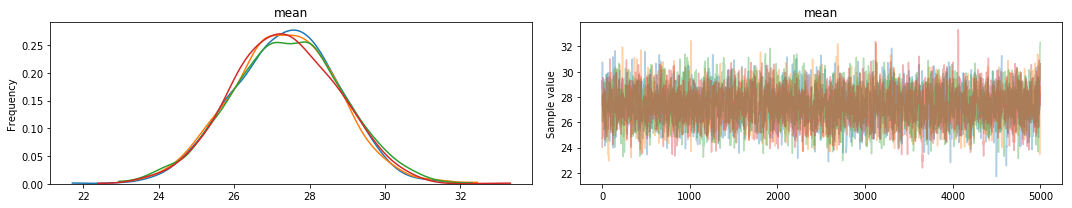

In [37]:
pm.traceplot(trace, figsize=(15, 3));

In [40]:
print "True mean: ", height_mean
print "Estimated mean: ",  trace['mean'].mean()

True mean:  50
Estimated mean:  27.361269945866766


### On the imprtance of Prior

In [41]:
with pm.Model() as black_forest_model:
    
    # define prior for all the groups
    mean = pm.Normal('mean', mu=50, sd=30)
    
    # define the likelihood (we are assuming a normal distributin):
    likelihood = pm.Normal('likelihood',mu=mean, sd=height_variance, observed=trees_height)

In [42]:
with black_forest_model:

    # instantiate sampler
    step = pm.Metropolis()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mean]
The number of effective samples is smaller than 25% for some parameters.


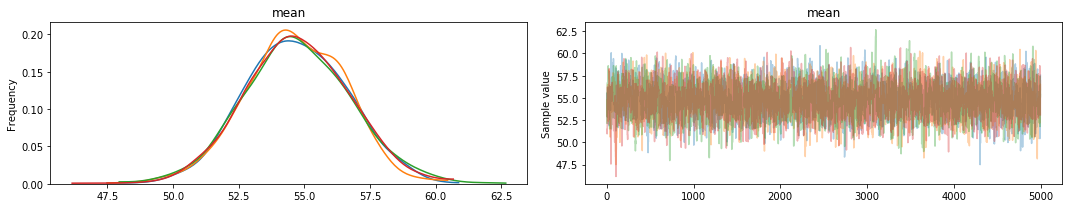

In [43]:
pm.traceplot(trace, figsize=(15, 3));

In [44]:
print "True mean: ", height_mean
print "Estimated mean: ",  trace['mean'].mean()

True mean:  50
Estimated mean:  54.710772830352546


---

## Unknown variance, unknown mean

In [45]:
sample_size = 100
samples = 1
height_mean = 50 
height_variance = 20 

trees_height = gen_tree_height(sample_size, samples, height_mean, height_variance)

In [26]:
with pm.Model() as black_forest_model:
    
    # define prior for all the groups
    mean = pm.Normal('mean', mu=50, sd=10)
    variance = pm.HalfNormal('variance', sd=2)
    
    # define the likelihood (we are assuming a normal distributin):
    likelihood = pm.Normal('likelihood',mu=mean, sd=variance, observed=trees_height)

In [27]:
with black_forest_model:
    
    # instantiate sampler
    step = pm.Metropolis()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [variance]
>Metropolis: [mean]
c:\users\mohammad bashiri\anaconda3\envs\pydatabayes2\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
The number of effective samples is smaller than 10% for some parameters.


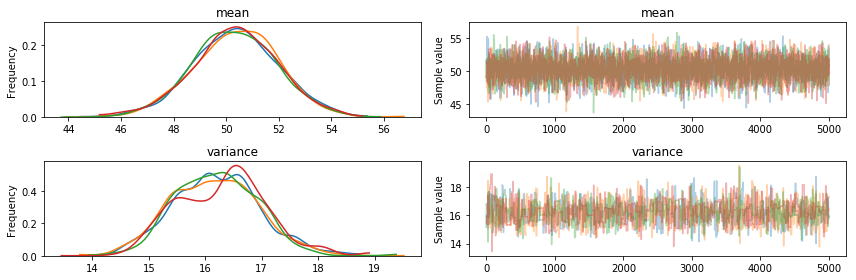

In [29]:
pm.traceplot(trace);

In [33]:
print "True mean: ", height_mean
print "Estimated mean: ",  trace['mean'].mean()

print "True variance: ", height_variance
print "Estimated variance:", trace['variance'].mean()

True mean:  50
Estimated mean:  50.360478415031345
True variance:  20
Estimated variance: 16.217774188457717


### On the importance of the sample size

In [46]:
sample_size = 100000
samples = 1
height_mean = 50 
height_variance = 20 

trees_height = gen_tree_height(sample_size, samples, height_mean, height_variance)

In [47]:
with pm.Model() as black_forest_model:
    
    # Define prior
    mean = pm.Normal('mean', mu=50, sd=20)
    variance = pm.HalfNormal('variance', sd=2)
    
    # Defin likelihood function
    likelihood = pm.Normal('likelihood', mu=mean, sd=variance, observed=trees_height)

In [48]:
with black_forest_model:
    step = pm.Metropolis()
    trace = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [variance]
>Metropolis: [mean]
The number of effective samples is smaller than 10% for some parameters.


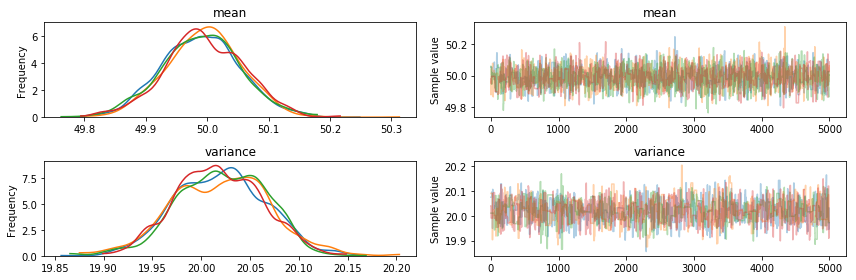

In [50]:
pm.traceplot(trace);

In [51]:
print "True mean: ", height_mean
print "Estimated mean: ",  trace['mean'].mean()

print "True variance: ", height_variance
print "Estimated variance:", trace['variance'].mean()

True mean:  50
Estimated mean:  49.99283976676189
True variance:  20
Estimated variance: 20.02000509227289


---

# Linear Regression

## Data

In [108]:
def gen_data_lr(n, x_range, beta_0=None, beta_1=None, theta_0=None, theta_1=None):
    
    beta_0 = beta_0 if beta_0 else 20
    beta_1 = beta_1 if beta_1 else .3
    theta_0 = theta_0 if theta_0 else 5
    theta_1 = theta_1 if theta_1 else 0.05
    
    X_vals, (X, Y) = np.arange(*x_range), np.zeros((2, n))
    for ind in range(n):
        X[ind] = sample(list(X_vals), 1)[0]
        y_mean = beta_0 + beta_1 * X[ind]
        y_variance = theta_0 + theta_1 * X[ind]
        Y[ind] = np.random.normal(loc=y_mean, scale=y_variance) if (theta_0 or theta_1) else y_mean
        
    return X, Y, beta_0, beta_1, theta_0, theta_1

The mountain has a height of 500 meters. So we started from 0 meter to 500 meters and ee sampled 10000 trees every 5 meter.

In [112]:
mountain_height, trees_height, beta_0, beta_1, theta_0, theta_1 = gen_data_lr(n=10000, x_range=(0, 500, 10))

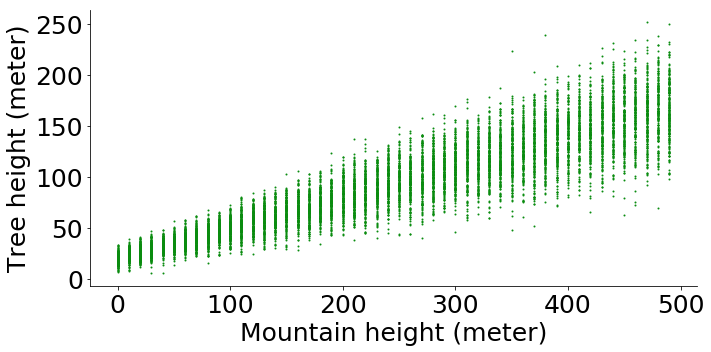

In [127]:
fig, ax = plt.subplots(figsize=(10,5))
sns.despine(top=True)

color = np.array([10, 140, 15]) / 255.
ax.scatter(mountain_height, trees_height, s=1, c=tuple(color));

# mask_value = mountain_height[int(mountain_height.shape[0])*.75]
# Y_line = trees_height[mountain_height==mask_value]
# ax.scatter(np.zeros(Y_line.shape) + mask_value, Y_line, s=1, c='r');

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.ylabel('Tree height (meter)', fontsize=25)
plt.xlabel('Mountain height (meter)', fontsize=25)
plt.tight_layout();

## Unknown variance, unknown mean, mean dependent on explanatory variable (e.g., X)

## Unknown variance, unknown mean, both dependent on explanatory variable (e.g., X)